<a href="https://colab.research.google.com/github/rubyvanrooyen/radio-astronomy-for-beginners/blob/master/SolarBrightnessTemperature/tutorial/RadioAstronomy_with_a_SatelliteDish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone Git repository with images for processing and notebooks of interest

In [1]:
!git clone https://github.com/ska-sa/radio-astronomy-for-beginners.git

Cloning into 'radio-astronomy-for-beginners'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 112 (delta 39), reused 112 (delta 39), pack-reused 0
Receiving objects: 100% (112/112), 18.16 MiB | 8.66 MiB/s, done.
Resolving deltas: 100% (39/39), done.


# Radio Astronomy with a Satellite Dish

Michael Gaylard    
Hartebeesthoek Radio Astronomy Observatory

A "classic" radio telescope comprises a circular parabolic reflector with a feed horn at the focus to collect the
incoming microwaves and pass them to transistor amplifiers in a receiver. A DSTV satellite dish also works
in this way. It can be used as a mini-radio telescope by replacing the DSTV decoder with a radiometer for
measuring the signal strength.

Refer to project description `radio_astronomy_with_a_satellite_dish.pdf` for theory and detailed project description.

## Gaussian fit to drift scan data

The Half-Power Beamwidth can be measured if the satellite dish is mounted so that its azimuth and elevation can be set and measured to an accuracy better than a degree.

Then it is possible to set it to carry out a “drift scan” across the Sun. The drift scan will give a cross-section of the antenna beam pattern. The HPBW is the width between the points at which the signal is half its maximum value.

To do this a prediction of the Sun’s position is needed - use a program such as Starcalc (https://www.calsky.com/cs.cgi/Sun/1) to predict its position in the near future. Recall that the Sun moves 1 degree in four minutes, so use the estimated separation of the first minima of the beam to calculate how far ahead you must position the antenna.

In [2]:
import matplotlib.pylab as plt
import numpy as np

Input the measured or example data

In [3]:
# read drift scan data
filename = '/content/radio-astronomy-for-beginners/SolarBrightnessTemperature/tutorial/NASSP_2009_ped_sun_drift_scan_project.csv'  # example data file

with open(filename, 'r') as fin:
    # ignore header line
    header = fin.readline()
    # get data
    text = fin.readlines()

data = []
for line in text:
    # extract measured data and timestamps
    data.append(np.array(line.strip().split(';')[2:], dtype=float))
data = np.asarray(data)

voltages = data[:, 0]
timestamps = data[:, 1]

Extract relevant measurements for calibration and calculation.

On target and off target measurements will be used for calibration, while the last pointing observation will be used to calculate the Solar brightness temperature.

In [4]:
# Off target measurments using timestamps 300 seconds to 600 seconds
V1 = np.mean(voltages[300:600])
# On target measurments using timestamps 2200 seconds to 2300 seconds
V2 = np.mean(voltages[2200:2300])
# Measurements from pointing using timestamps 3795 seconds to 3835 seconds
V3 = np.mean(voltages[3795:3835])

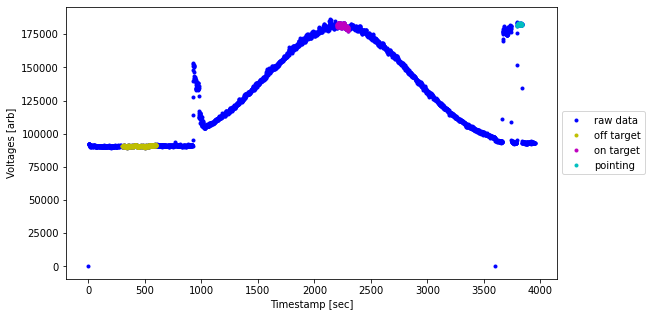

In [5]:
fig= plt.subplots(figsize=(11,5),
                  facecolor='white')
ax = plt.subplot(111)
ax.plot(timestamps, voltages, 'b.', label='raw data')
ax.plot(timestamps[300:600], voltages[300:600], 'y.', label='off target')
ax.plot(timestamps[2200:2300], voltages[2200:2300], 'm.', label='on target')
ax.plot(timestamps[3795:3835], voltages[3795:3835], 'c.', label='pointing')
ax.set_ylabel('Voltages [arb]')
ax.set_xlabel('Timestamp [sec]')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Units of time are converted to angle by noting that the Sun moves through 1 degree in 4 minutes / cos(declination). The Sun's declination is how far north or south of the equator it is at the time of observation. Its declination is -23.44$^\circ$ on about Dec 21, 0$^\circ$ on March 21 and September 21, and +23.44$^\circ$ on June 21. It follows a sinusoidal path between those dates.

Convert time [sec] to scan angle [deg]   
$\delta = \frac{t}{240}\cos(\mbox{radians}(10))$

In [6]:
scan_angle = timestamps/240. *np.cos(np.radians(10))

Gaussian fit parameters   
$g(x) = B + A \exp \left( \frac{-(\delta - P)^2}{2w^2} \right)$,   
where $B$ is a bias offset, $A$ is amplitude, $P$ is the peak position (mean) and $2w$ the HPBW (standard deviation).

In [7]:
# Read / estimate gaussian fit parameters from data
B = 90000
A = 91500
W = 2.55
P = 9.1
gaussian_fit = B + A * np.exp(-((scan_angle - P)**2) / (2*(W**2)))

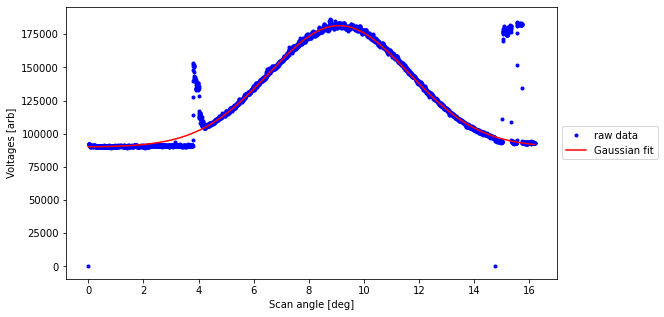

In [8]:
fig= plt.subplots(figsize=(11,5),
                  facecolor='white')
ax = plt.subplot(111)
ax.plot(scan_angle, voltages, 'b.', label='raw data')
ax.plot(scan_angle, gaussian_fit, 'r', label='Gaussian fit')
ax.set_ylabel('Voltages [arb]')
ax.set_xlabel('Scan angle [deg]')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Calibrating the Radio Telescope

The satellite dish produces an output voltage proportional to the sum of the temperature of the object it is
pointed at plus its own internal receiver temperature. We need to establish a scale of Kelvins per radiometer
output unit. We do this by using the sky at zenith as a "cold load", and the ground as a "hot load".

In [9]:
# Cold load
Tsky = 7  # K

# Hot load
Tground = 290  # K (measured, or estimated from current temp)

Calculate $c$ and $T_R$ from   
[1] $T_R + T_{sky} = cV_1$    
[2] $T_R + T_{ground} = cV_2$

Getting the voltage to temperature scale factor by subtracting Equation 2 from Equation 1:   
$T_{ground} - T_{sky} = c(V_2 - V_1)$

This can be recognised as the well known Y-factor calculation:    
Y  = $\frac{T_{hot}-T_{cold}}{T_{on}-T_{off}}$

As well as $T_R$ from Equation 1

In [10]:
c = (Tground - Tsky)/(V2 - V1)
print(f'Voltage to temperature scale factor c = {c}')
Tr = c*V1 - Tsky  # [K]
print(f'Receiver temperature Tr = {Tr:.3f} [K]')

Voltage to temperature scale factor c = 0.003129980185214098
Receiver temperature Tr = 277.094 [K]


From a pointing at the Sun, get a reading V3 and calculate the antenna temperature of the Sun   
[3] $T_R + T_{sky} + T_A = c V_3$

In [11]:
Ta = c*V3 - Tsky - Tr  # [K]
print(f'Measured antenna temperature of the Sun Ta = {Ta:.3f} [K]')

Measured antenna temperature of the Sun Ta = 287.471 [K]


To obtain the brightness temperature $T_B$ of the emitter from its measured antenna temperature $T_A$, we
measure the angular sizes of the emitter and the telescope beam and correct for these. Thus, we need the angular diameters of the Sun and the telescope beam to get their solid angles.

The first minimum or null in the pattern occurs at a radius of about $1.2 * \lambda/D$ radians, so the beamwidth to first nulls is   
$ BWFN = 2.4 \lambda/D$ [radians].

The beamwidth at the half-power points (HPBW), also called the Full Width at Half Maximum (FWHM) is about half the BWFN:    
$HPBW = FWHM \approx 1.1\lambda/D$ [radians].

In [12]:
HPBW = 2.* W  # [deg]
print(f'Antenna half-power beam-width from drift scan HPBW = {HPBW} [deg]')

Antenna half-power beam-width from drift scan HPBW = 5.1 [deg]


As the projection of the antenna beam onto the sky is two-dimensional, we shall need to find the angular area that
it covers. Angular area is called a "solid angle" and the units are radians$^2$, or steradians (sr).

The beam solid angle $\Omega_{GB}$ of a Gaussian beam can be obtained from the HPBW - in units of radians - using    
[4] $\Omega_{GB} = \frac{\pi}{4\ln 2} (HPBW)^2 \approx 1.133(HPBW)^2$ [sr].

In [13]:
Obeam = 1.133 * np.radians(HPBW)**2  # [sr]
print(f'Solid angle for Gaussian beam Obeam = {Obeam} [sr]')

Solid angle for Gaussian beam Obeam = 0.008976871267443044 [sr]


Including allowance for the beam efficiency of a typical reflector antenna ($85\%$).    
$\eta_b = \frac{\Omega_{GB}}{\Omega_A} => \Omega_A = \frac{\Omega_{GB}}{\eta_b}$    
[5] $\Omega_A = \frac{1.133 HPBW^2}{0.85} = 1.33294 \times HPBW^2 \approx 4/3 \times HPBW^2$ [sr].

In [14]:
Oa = Obeam/0.85
print(f'Beam solid angle Oa = {Oa} [sr]')

Beam solid angle Oa = 0.010561025020521229 [sr]


An object with an angular radius $\theta$ radians subtends a solid angle   
[6] $\Omega = 2\pi(1 − \cos \theta)$ [sr].

For small $\theta$,
$\Omega = \pi\theta^2$ [sr].
We can use this equation to calculate the solid angle of the Sun, $\Omega_s$

In [15]:
Os = np.pi * np.radians(0.6/2)**2  # [sr]
print(f'Solid angle of the Sun Os = {Os} [sr]')

Solid angle of the Sun Os = 8.612854633416615e-05 [sr]


The Sun's brightness temperature $T_B$ can then be estimated by scaling its measured antenna temperature $T_A$ by the ratio of the beam solid angle $\Omega_A$ to the Sun's solid angle $\Omega_s$:

[7] $T_B = \frac{\Omega_A T_A}{\Omega_s}$ [K].

In [16]:
Tb = Oa*Ta / Os  # [K]
print(f'Estimated brightness temperature of the Sun Tb = {Tb:.2f} [K]')

Estimated brightness temperature of the Sun Tb = 35249.53 [K]
